In [95]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold,StratifiedKFold
import albumentations as A
import cv2
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
np.random.seed(42)

# Format Data

In [96]:
def permute(image):
    image = torch.Tensor(image)
    image = image.permute(2,0,1).numpy()
    return image

In [97]:
DATA_PATH = '../data/aptos_dataset/raw_data/aptos2019-blindness-detection/train_images/'
OUT_PATH = '../data/aptos_dataset/processed_data/'
TABLE_PATH = '../data/split_tables/aptos/'
os.makedirs(TABLE_PATH,exist_ok=True)
os.makedirs(OUT_PATH,exist_ok=True)

df = pd.read_csv('../data/aptos_dataset/raw_data/aptos2019-blindness-detection/train.csv')

df['target'] = 0
df['target'][df['diagnosis']>= 2] = 1

df

/home/dmitrii/anaconda3/envs/dmitrii_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,id_code,diagnosis,target
0,000c1434d8d7,2,1
1,001639a390f0,4,1
2,0024cdab0c1e,1,0
3,002c21358ce6,0,0
4,005b95c28852,0,0
...,...,...,...
3657,ffa47f6a7bf4,2,1
3658,ffc04fed30e6,0,0
3659,ffcf7b45f213,2,1
3660,ffd97f8cd5aa,0,0


In [98]:
images_list = df['id_code'].unique().tolist()

In [128]:
def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    

    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [131]:
sigmaX=10

for image_name in tqdm(images_list):
    
    
    image = cv2.imread(DATA_PATH+f'{image_name}.png') 
    image  = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cut_x = abs(image.shape[0] - min(image.shape[:2]))//2
    cut_y = abs(image.shape[1] - min(image.shape[:2]))//2
    
    image = circle_crop(image) #image[cut_x:-(cut_x+1),cut_y:-(cut_y+1),:]
    #image = cv2.copyMakeBorder(image,padding_x,padding_x,padding_y,padding_y,cv2.BORDER_CONSTANT,value=[0,0,0])
    
    image = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
    
    target = df[df['id_code']==image_name]['target'].values[0]
    
    
    
    np.save(OUT_PATH+f'{image_name}.npy',image)
    np.save(OUT_PATH+f'{image_name}_label.npy',target)
    

100%|██████████| 3662/3662 [11:24<00:00,  5.35it/s]


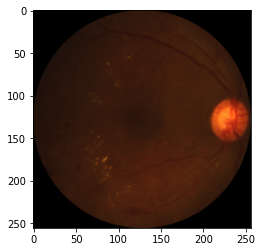

In [132]:
plt.imshow(image)

In [119]:
image.shape

(2135, 2135, 3)

In [102]:
cut_y

0

# Prepare split tables

In [63]:
images_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('label.npy')==-1]

print(f'Total number of images: {len(images_list)}')

images_list = np.array(images_list)

images_list = np.random.permutation(images_list)

Total number of images: 3662


In [64]:
#create test
kf = GroupKFold(n_splits=5)

for (train,test) in kf.split(images_list,images_list,images_list):
    
    records_test = images_list[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break



print(f'Number of images, test subset: {images_list[test].shape[0]}')

images_list = images_list[train]

Number of images, test subset: 733


In [65]:

#create train and validation
n_patients = [2,4,8]

n = images_list.shape[0]

for i in n_patients:
    
    records_train = images_list[:int(n*(i/100))].tolist()
    
    records_val = images_list[-1*int(n*(2/100)):].tolist()
    
    records_pretrain = images_list[int(n*(i/100)):].tolist()
    
    #create split
    split = {
            'train': records_train,
            'val': records_val,
            'pretrain': records_pretrain,
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)



            
    print(f'Number of unique images, train subset: {len(records_train)}')
    print(f'Number of samples, val subset: {len(records_val)}')
    print(f'Number of samples, pretain subset: {len(records_pretrain)}')
    print('#######################################################')

    


Number of unique images, train subset: 58
Number of samples, val subset: 58
Number of samples, pretain subset: 2871
#######################################################
Number of unique images, train subset: 117
Number of samples, val subset: 58
Number of samples, pretain subset: 2812
#######################################################
Number of unique images, train subset: 234
Number of samples, val subset: 58
Number of samples, pretain subset: 2695
#######################################################


In [66]:
#create UB



records_train = images_list[:int(n*0.8)].tolist()
records_train = images_list[:int(n*0.8)].tolist()

records_val = images_list[int(n*0.8):].tolist()



#create split
split = {
        'train': records_train,
        'val': records_val,
    }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
        json.dump(split, outfile)




print(f'Number of unique images, train subset: {len(records_train)}')
print(f'Number of samples, val subset: {len(records_val)}')
print('#######################################################')

Number of unique images, train subset: 2343
Number of samples, val subset: 586
#######################################################


# Review augs

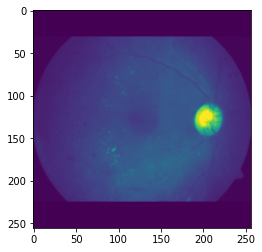

In [83]:
prob = 1
augs = A.Compose(
                [ 
#                     A.HorizontalFlip(p=prob),
#                     A.VerticalFlip(p=prob),
#                     A.Rotate(limit=90, p=prob),
#                     #A.ElasticTransform(alpha=0.1,p=prob),
#                     A.RandomSizedCrop(min_max_height=(120, 200), height=256, width=256, p=prob),
#                     A.RandomGamma(gamma_limit=(80, 180), p=prob),
#                     #A.GlassBlur(sigma=10),
#                     #A.GridDistortion(distort_limit=0.3)
#                     A.RandomBrightness(limit=-0.1,p=prob)
                ]
            )

augmented = augs(image=image-np.mean(image[50:150,50:150,:]))
augmented = augmented['image']


plt.imshow(augmented[:,:,0]/np.std(augmented[:,:,0]))

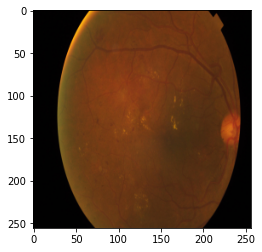

In [113]:
plt.imshow(image)

In [195]:
image.shape

(225, 300, 3)

In [ ]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

In [ ]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')